<a href="https://colab.research.google.com/github/evillag/TEC-ML-2022-1/blob/main/TP2/src_base/TP2_BayesianModel_MNIST_EVG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Aprendizaje Automático
# Trabajo Practico 2: Clasificador Bayes Ingenuo
**Escuela de Ingeniería en Computación | Instituto Tecnológico de Costa Rica**

Realizado por
*   Luis Badilla Ortiz
*   William Jiménez García
*   Esteban Villalobos Gómez

Fecha de entrega
*  15 de Mayo de 2022

Entrega
* Un archivo .zip con el código fuente LaTeX o Lyx, el pdf, y un notebook en jupyter, debidamente documentado, con una función definida por ejercicio. A través del TEC-digital.

Modo de trabajo
* Grupos de 3 personas.

En el presente trabajo práctico se introduce la implementación de redes bayesianas.
________________________


## A. Respuestas y análisis de resultados

3) **Entrene el modelo con el conjunto de observaciones contenido en la carpeta train, y reporte la tasa de aciertos al utilizar la función anteriormente implementada test_model_batch (se espera que la tasa de aciertos sea mayor a 80 %). Verifique y comente los resultados.**
<br><br>
R/ Model accuracy: $91.6667$%
<br><br>
Al realizar el entrenamiento y evaluación del modelo se obtuvo una tasa de aciertos del 91.6%, lo cual indica un alto grado de precisión. Luego de una revisión detallada de los datos y el score calculado en cada caso se pudo observar que las imagenes que fueron etiquetadas incorrectamente son dificiles de identificar incluso para el ojo humano, como la imagen de abajo que esta etiquetada como 1 y Bayes estimó que es un 8.

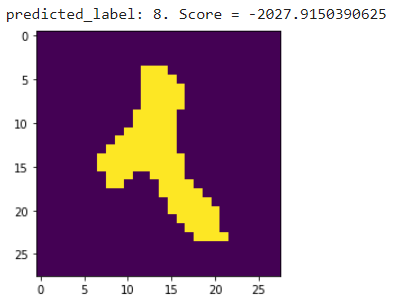

<br>

3) **(cont.) ... Si observa valores de 0 o nulos en la evaluación de la función, argumente el porqué puede deberse este comportamiento. ¿Cómo se puede corregir el problema detectado, según las herramientas matemáticas estudiadas en clase? Implemente tal enfoque y compruebe los resultados.**
<br><br>
R/ Al realizar la multiplicatoria de ∏ p(m|t) * p(t) se pudo observar que los valores eran muy bajos y llegaban a dar un resultado de cero, lo cual anulaba completamente el algoritmo. A esto se le conoce como un problema de underflow que resulta de calcular el producto de muchos números de magnitud menor que uno. 
<br><br>
Para evitar este problema se optó por calcular el logaritmo natural de la función de verosimilitud, lo cual convierte la multiplicatoria en una sumatoria de logaritmos naturales y dado que la sumatoria no decrese la magnitud del resultado, el problema de underflow se puede evitar. Lo que se busca es obtener el valor máximo por lo que la transformación logaritmica no afecta el resultado.
<br><br>


4) **Particione los datos de forma aleatoria con 70 % de las observaciones para entrenamiento y 30 % para prueba (a partir de la carpeta train). Calcule la tasa de aciertos para 10 corridas, cada una con una partición de entrenamiento y otra de prueba distintas. Reporte los resultados de las corridas en una tabla, además de la media y desviación estándar de la tasa de aciertos para las 10 corridas. Para realizar las particiones puede usar la libreria sklearn.**

R/ 

| Corrida | Accuracy |
|---------|---------|
|    1    | 0.4222 |
|    2    | 0.3944 |
|    3    | 0.4333 |
|    4    | 0.3888 |
|    5    | 0.4888 |
|    6    | 0.5111 |
|    7    | 0.3555 |
|    8    | 0.5111 |
|    9    | 0.4000 |
|   10    | 0.4833 |
| PROMEDIO| 0.4389 |
| S.D.    | 0.0559 |

<br>

Realizando estas pruebas se puede notar una gran disminución en el accuracy del modelo, esto puede deberse al desbalanceo de las muestras al momento de realizar el entrenamiento por la selección aleatoria de muestras en cada partición lo que aumenta las probabilidades para aquellos números que posean más muestras ocasionando que tengan más peso en las probabilidades al realizar una estimación.

<br>

5) **Estudie el efecto del desbalanceo de los datos descrito en la Tabla 1, como escenario. Realice 10 particiones de forma aleatoria, y calcula la media y desviacion estandar de los resultados. Compare y comente los resultados respecto a los resultados en el punto anterior con el dataset balanceado.**

R/

| Corrida | Accuracy |
|---------|--------|
|    1    | 0.3944 |
|    2    | 0.3777 |
|    3    | 0.3777 |
|    4    | 0.4000 |
|    5    | 0.4500 |
|    6    | 0.4111 |
|    7    | 0.4111 |
|    8    | 0.4222 |
|    9    | 0.3722 |
|   10    | 0.4500 |
| PROMEDIO| 0.4066 |
| S.D.    | 0.0266 |

<br>

Realizando las pruebas con el desbalanceo de las muestras para entrenamiento se observa un comportamiento similar al que ocurre con la generación de particiones, es decir el accuracy del modelo disminuye considerablemente en comparación al modelo entrenado con un dataset balanceado, esto puede deberse a las desigualdades en las probabilidades que pueden ocasionar que algunas clases tengan más peso al realizar las estimaciones del modelo.

<br>

Un punto a resaltar es que la desviación estándar del modelo con datos desbalanceados es menor a la obtenida al particionar los datos, esto puede deberse a que en el desbalanceo aún mantenemos una proporción equivalente entre las muestras de las clases en cada iteración sin embargo en el particionamiento esta proporción puede variar debido a que la selección es aleatoria por cada split.


________________________

## B. Código fuente

### Imports

In [ ]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import ShuffleSplit

### Get Data

In [ ]:
%%capture
!wget https://github.com/evillag/TEC-ML-2022-1/raw/main/TP2/src_base/mnist_dataset.zip
!unzip /content/mnist_dataset.zip

### Load Data
####Punto: 1)


In [ ]:
def binarize_image(image_tensor):
    image_tensor[image_tensor > 0.5] = 1
    image_tensor[image_tensor <= 0.5] = 0
    return image_tensor

def load_dataset(path = "mnist_dataset/train"):
    #Open up the dataset
    dataset =  torchvision.datasets.ImageFolder(path)   
    list_images = dataset.imgs
    train_data_tensor = None    
    labels_training = []
    first_tensor = True
    for i in range(len(list_images)):
        pair_path_label = list_images[i]        
        image = Image.open(pair_path_label[0]) 
        x_tensor = TF.to_tensor(image).squeeze()
        x_tensor_bin = binarize_image(x_tensor)
        x_tensor_bin_plain = x_tensor_bin.view(x_tensor_bin.shape[0] * x_tensor_bin.shape[1], -1)           
        labels_training += [pair_path_label[1]]
        if(first_tensor):
            #plt.figure()
            #plt.imshow(x_tensor_bin)
            first_tensor = False
            train_data_tensor = x_tensor_bin_plain
        else:
            train_data_tensor = torch.cat((train_data_tensor, x_tensor_bin_plain), 1)    
    return (train_data_tensor, torch.tensor(labels_training))            

In [ ]:
# Load Data
print("LOADING DATA")
(train_data_tensor, labels_training) = load_dataset(path = "/content/mnist_dataset/train")
print("Train data dimensions: ", train_data_tensor.shape)
print("Train labels dimensions: ", len(labels_training))  
print("LOADING DATA: COMPLETE\n")

LOADING DATA
Train data dimensions:  torch.Size([784, 600])
Train labels dimensions:  600
LOADING DATA: COMPLETE



### Train Model
#### Puntos: 2.a) 2.b) 2.c)

In [ ]:
def train_model(train_data_tensor, labels_training, num_classes = 10):
  p_m_0_given_k = torch.zeros(num_classes, train_data_tensor.shape[0])
  p_m_1_given_k = torch.ones(num_classes, train_data_tensor.shape[0])
  
  _, counts = torch.unique(labels_training, return_counts=True)
  p_t_tensor = counts / len(labels_training)

  for k in range(num_classes):
    training_indices_of_class_k = (labels_training == k).nonzero().squeeze(1)
    M_d = train_data_tensor[:, training_indices_of_class_k]

    # p(m = 0 | k) =>  (observations == 0) / (total observations of class k)
    p_m_0_given_k[k, :] = (M_d == 0.).sum(dim=1).div(M_d.shape[1])

  # calculate complement => p(m = 1 | k)
  p_m_1_given_k = p_m_1_given_k - p_m_0_given_k

  return [p_m_0_given_k, p_m_1_given_k], p_t_tensor

### Test Model
#### Punto: 2.d)

In [ ]:
def test_model(input_torch, p_m_pix_val_given_k, p_t_tensor, 
                               num_classes = 10):
    # assumes that the input comes in a row
    # Since the multiplicatory tends to give very small values, close to 0
    # We are transforming the Naive Bayes by applying a log to it, so that:
    # log(Mul(p(m|t)p(t))) = Sum(log(p(m|t)) + log(p(t)))

    prob_naive_bayes = torch.zeros(num_classes, train_data_tensor.shape[0])
    scores_classes = torch.zeros(10)

    idx_0 = (input_torch == 0.) # indices of all pixels in 0
    idx_1 = (input_torch == 1.) # indices of all pixels in 1

    # probability of pixels = 0 given k:
    prob_naive_bayes[:, idx_0] = torch.log(p_m_pix_val_given_k[0][:, idx_0]) + torch.log(p_t_tensor.view(num_classes, 1))

    # probability of pixels = 1 given k:
    prob_naive_bayes[:, idx_1] = torch.log(p_m_pix_val_given_k[1][:, idx_1]) + torch.log(p_t_tensor.view(num_classes, 1))

    # calculate the class probability
    scores_classes = torch.sum(prob_naive_bayes, 1)

    values, indices = scores_classes.topk(1)

    predicted_label = indices.item()

    #print(f'predicted_label: {indices[0]}. Score = {values[0]}')
    
    return predicted_label, scores_classes

### Test Model Batch
#### Punto: 2.e)

In [ ]:
def test_model_batch(test_set, labels, p_m_pix_val_given_k, p_t_tensor):
    correct = 0
    
    for i in range(labels.shape[0]):
      predicted_label, _ = test_model(test_set[:,i], p_m_pix_val_given_k, 
                                      p_t_tensor)
      correct += 1 if predicted_label == labels[i] else 0
      # print(f'predicted = {predicted_label}. real = {labels[i]}')

    accuracy = correct / labels.shape[0]
    return accuracy

### Training model and testing using batches
#### Punto: 3)

In [ ]:
#Training model by calculating the prior probabilities
print("TRAINING MODEL")
(p_m_pix_val_given_k, p_t_tensor) = train_model(train_data_tensor, labels_training)
print(f"p_m_pix_val_given_k[0] size {p_m_pix_val_given_k[0].shape}")
print(f"p_m_pix_val_given_k[1] size {p_m_pix_val_given_k[1].shape}")
print(f"p_t_tensor: {p_t_tensor}")
print("TRAINING MODEL: COMPLETE\n")

# Testing model by batchs
print("TESTING MODEL, Batchs")
acc = test_model_batch(train_data_tensor, labels_training, p_m_pix_val_given_k, p_t_tensor)
print(f"Model accuracy: {round(acc * 100, 4)}%")
print("TESTING MODEL, Batchs: COMPLETE")

TRAINING MODEL
p_m_pix_val_given_k[0] size torch.Size([10, 784])
p_m_pix_val_given_k[1] size torch.Size([10, 784])
p_t_tensor: tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000])
TRAINING MODEL: COMPLETE

TESTING MODEL, Batchs
Model accuracy: 91.6667%
TESTING MODEL, Batchs: COMPLETE


### Test Model Batch: Partitions
#### Punto: 4)

In [ ]:
def partition_validation(train_data_tensor, labels_data_tensor, num_splits):
  """
  Create and test dataset partitions
  """

  # Shuffle Split
  shuffle_split = ShuffleSplit(n_splits=num_splits, test_size=.30) 
  
  # Iteration counter
  iteration = 1

  # Results
  results = torch.zeros(num_splits)

  train_data_tensor = train_data_tensor.T

  for train_index, test_index in shuffle_split.split(train_data_tensor):

    print(f"Iteration: {iteration}")
    
    # Get Train Data
    train_torch = train_data_tensor[train_index, :]
    labels_training = labels_data_tensor[train_index]

    # Get Test Data
    test_torch = train_data_tensor[test_index]
    labels_testing = labels_data_tensor[test_index]

    # TRAIN
    print("===== TRAINING =====")
    (p_m_pix_val_given_k, p_t_tensor) = train_model(train_torch.T, labels_training)
    print(p_t_tensor)
    
    # TEST
    print("===== TESTING =====")
    acc = test_model_batch(test_torch.T, labels_testing, p_m_pix_val_given_k, p_t_tensor) # Test with test data
    #acc = test_model_batch(train_torch.T, labels_training, p_m_pix_val_given_k, p_t_tensor) # Test with train data
    print(f"Model accuracy: {round(acc * 100, 4)}%\n")

    # Append Accuracy Result
    results[iteration - 1] = (round(acc, 4))

    # Add +1 to current iteration
    iteration += 1

  return results

accuracies = partition_validation(train_data_tensor, labels_training, 10)
print("===== RESULT =====")
print("Accuracies: ", accuracies)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())

Iteration: 1
===== TRAINING =====
tensor([0.0929, 0.0833, 0.1071, 0.1071, 0.1000, 0.1000, 0.1143, 0.1000, 0.0905,
        0.1048])
===== TESTING =====
Model accuracy: 43.3333%

Iteration: 2
===== TRAINING =====
tensor([0.1024, 0.1048, 0.1119, 0.1024, 0.1024, 0.0952, 0.1000, 0.0976, 0.0929,
        0.0905])
===== TESTING =====
Model accuracy: 47.7778%

Iteration: 3
===== TRAINING =====
tensor([0.1095, 0.0881, 0.1071, 0.1071, 0.0952, 0.0976, 0.0905, 0.1048, 0.1000,
        0.1000])
===== TESTING =====
Model accuracy: 44.4444%

Iteration: 4
===== TRAINING =====
tensor([0.0905, 0.1048, 0.0952, 0.1024, 0.0976, 0.1048, 0.0929, 0.1119, 0.1024,
        0.0976])
===== TESTING =====
Model accuracy: 51.1111%

Iteration: 5
===== TRAINING =====
tensor([0.1048, 0.1024, 0.1048, 0.1119, 0.0952, 0.1048, 0.0905, 0.0952, 0.0976,
        0.0929])
===== TESTING =====
Model accuracy: 48.3333%

Iteration: 6
===== TRAINING =====
tensor([0.1167, 0.0857, 0.0976, 0.1000, 0.1024, 0.1071, 0.1024, 0.0976, 0.0881,
 

### Test Model: Unbalanced Data
#### Punto: 5)

In [ ]:
def create_unbalanced_data_set(train_data_tensor, labels_training, num_classes):
  no_test_samples = 18
  no_train_samples = [22, 22, 22, 22, 22, 42, 42, 42, 42, 42]

  train_data = torch.tensor([])
  train_labels = torch.tensor([])

  test_data = torch.tensor([])
  test_labels = torch.tensor([])

  for current_class in range(num_classes):
    train_data_current_class = train_data_tensor[:, labels_training == current_class]
    labels_current_class = labels_training[labels_training == current_class]

    # Indexes to create a random dataset
    indexes = [i for i in range(train_data_current_class.shape[1])]
    random.shuffle(indexes)

    # Test Data
    indexes_test_data = indexes[:no_test_samples] # Get data from [0, 18[
    test_data_temp = train_data_current_class[:, indexes_test_data]
    test_data = torch.cat((test_data, test_data_temp), 1)
    
    # Test Labels
    test_labels = torch.cat((test_labels, labels_current_class[indexes_test_data])) 

    # Train Data
    indexes_train_data = indexes[no_test_samples: no_test_samples + no_train_samples[current_class]] # Get data from [18, (40 || 60)[
    train_data_temp = train_data_current_class[:, indexes_train_data]
    train_data = torch.cat((train_data, train_data_temp), 1)

    # Train Labels
    train_labels = torch.cat((train_labels, labels_current_class[indexes_train_data]))

  #print((train_data, train_labels, test_data, test_labels))
  return (train_data, train_labels, test_data, test_labels)

# Variables
num_classes = 10
accuracies = torch.zeros(num_classes)

# Create 10 partitions
for current_class in range(num_classes):

  print(f"=== Iteration: {current_class + 1} ===")

  # Create Data
  (train_data, train_labels, test_data, test_labels) = create_unbalanced_data_set(train_data_tensor, labels_training, num_classes)

  # TRAIN
  print("===== TRAINING =====")
  (p_m_pix_val_given_k, p_t_tensor) = train_model(train_data, train_labels)
  print("p_t tensor:", p_t_tensor)

  # TEST
  print("===== TESTING =====")
  acc = test_model_batch(test_data, test_labels, p_m_pix_val_given_k, p_t_tensor) # Test with test data
  #acc = test_model_batch(train_torch.T, labels_training, p_m_pix_val_given_k, p_t_tensor) # Test with train data
  print(f"Model accuracy: {round(acc * 100, 4)}%\n")

  accuracies[current_class] = acc

print("===== RESULT =====")
print("Accuracies: ", accuracies)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())

=== Iteration: 1 ===
===== TRAINING =====
p_t tensor: tensor([0.0688, 0.0688, 0.0688, 0.0688, 0.0688, 0.1312, 0.1312, 0.1312, 0.1312,
        0.1312])
===== TESTING =====
Model accuracy: 35.5556%

=== Iteration: 2 ===
===== TRAINING =====
p_t tensor: tensor([0.0688, 0.0688, 0.0688, 0.0688, 0.0688, 0.1312, 0.1312, 0.1312, 0.1312,
        0.1312])
===== TESTING =====
Model accuracy: 42.7778%

=== Iteration: 3 ===
===== TRAINING =====
p_t tensor: tensor([0.0688, 0.0688, 0.0688, 0.0688, 0.0688, 0.1312, 0.1312, 0.1312, 0.1312,
        0.1312])
===== TESTING =====
Model accuracy: 47.2222%

=== Iteration: 4 ===
===== TRAINING =====
p_t tensor: tensor([0.0688, 0.0688, 0.0688, 0.0688, 0.0688, 0.1312, 0.1312, 0.1312, 0.1312,
        0.1312])
===== TESTING =====
Model accuracy: 42.2222%

=== Iteration: 5 ===
===== TRAINING =====
p_t tensor: tensor([0.0688, 0.0688, 0.0688, 0.0688, 0.0688, 0.1312, 0.1312, 0.1312, 0.1312,
        0.1312])
===== TESTING =====
Model accuracy: 43.8889%

=== Iteration: 